#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### O que é o índice Ibovespa 

É o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.


https://pt.wikipedia.org/wiki/Ibovespa

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

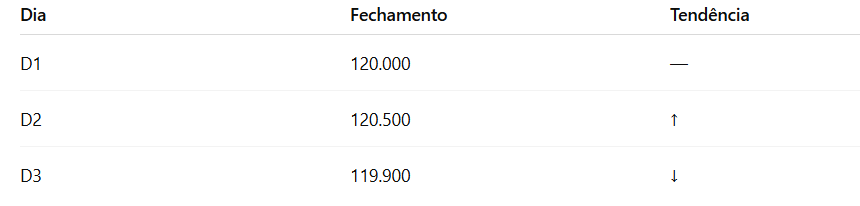

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [ ]:
# Importar biblioteca completa
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import calendar
import pandas_ta as ta

# Importar função especifica de um módulo
from statsmodels.tsa.seasonal import seasonal_decompose # --> Geral a decomposição dos dados
from sklearn.preprocessing import StandardScaler
from datetime import date

# Importar função especifica de um módulo --> Modelos de ML
from sklearn.ensemble import RandomForestClassifier # --> Modelo de ML Random Forest
from sklearn.linear_model import LogisticRegression # --> Modelo de ML Regressão Logistica 
from catboost import CatBoostClassifier # --> Modelo de ML CatBoost
from lightgbm import LGBMClassifier # --> Modelo de ML LightGBM
from xgboost import XGBClassifier # --> Modelo de ML XGBoost
from sklearn.svm import SVC # --> Modelo de ML SVC

# Importar função especifica de um módulo --> Metricas para analisar o modelo  
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Outros import
import ipywidgets as widgets


##### Criação de funções (DEF)

In [ ]:
# Função que gera os gráficos para um modelo escolhido
def analisar_modelo_selecionado(nome_modelo):
    
    # Pega o modelo e as previsões do nosso dicionário central
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]
    previsoes_selecionadas = modelos_avaliados[nome_modelo]["previsoes"]

    print(f"\n--- Análise Detalhada para o Modelo: {nome_modelo} ---")
    
    # --- Gráfico 1: Matriz de Confusão ---
    cm = confusion_matrix(y_test, previsoes_selecionadas)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1) # Cria um subplot na posição 1
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Previsto Negativo', 'Previsto Positivo'], 
                yticklabels=['Real Negativo', 'Real Positivo'])
    plt.title(f'Matriz de Confusão - {nome_modelo}', fontsize=14)
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')

    # --- Gráfico 2: Curva ROC e AUC ---
    # Tratamento especial para SVM que pode não ter predict_proba por padrão
    if hasattr(modelo_selecionado, "predict_proba"):
        y_pred_proba = modelo_selecionado.predict_proba(x_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.subplot(1, 2, 2) # Cria um subplot na posição 2
        plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Classificador Aleatório')
        plt.xlabel('Taxa de Falsos Positivos (FPR)')
        plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.legend()
        plt.grid()
    else:
        # Caso o modelo não suporte predict_proba
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Curva ROC não disponível\npara este modelo (ex: SVM sem probabilidade).', 
                 ha='center', va='center', fontsize=12)
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.gca().set_axis_off()


    plt.tight_layout() # Ajusta o espaçamento entre os gráficos
    plt.show()

##### Análise Exploratória de Dados (EDA)

In [ ]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance apenas para referencia
# progress --> Não gerar um print do progresso
# auto_adjust --> corrigir o histórico de preços
# multi_level_index --> Utilizando para evitar gerar coluna com o nome do ticket, exemplo ('Close', '^BVSP')

dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)

print("Primeiros dados")
display(dados_yf.head())

print("\nUltimos dados")
display(dados_yf.tail())

In [ ]:
# Opção de já transformar o campa data em Data e Index

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem_teste = pd.read_csv(link, sep= ";", thousands='.', decimal=',', parse_dates=["Data"], dayfirst=True, index_col="Data")
display(dados_origem_teste.head())

In [ ]:
# Importar os dados via github 
# Necessario o uso do arumento thousands e decimal para não ter problema com o data frame --> o . na fonte é para separar o milhar

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem = pd.read_csv(link, sep= ";", thousands='.', decimal=',', index_col="Data")

In [ ]:
# Verificando os dados via .head e .tail

print("Primeiros dados (.head)")
display(dados_origem.head())

print("\nUltimos dados (.tail)")
display(dados_origem.tail())

In [ ]:
# Ajustar o formato da coluna Data 

dados_origem.index = pd.to_datetime(dados_origem.index, format = "%d/%m/%Y")

In [ ]:
# Verificand os dados os dados do data frame dados_origem com o dados_yf --> Verificar se há diferença 

print("Dados do data frame dados_origem")
display(dados_origem[['Ultimo', 'Abertura', 'Maxima', 'Minima']].tail())

print("\nDados do data frame dados_yf")
display(dados_yf[['Close', 'Open', 'High', 'Low']].query("Date >= '2025-06-30 00:00:00' and Date <= '2025-07-04 00:00:00'"))


In [ ]:
# Veficiando os dados dados do data frame 

dados_origem.info()

In [ ]:
# Verificando os dados nulos
dados_origem.isnull().sum()

In [ ]:
# Verificando os registros que estão nulos 
# Como para o nosso projeto esse campo Volume não é util, vamos manter esse registro
dados_origem[dados_origem.isnull().any(axis=1)]

In [ ]:
# Gerando a estatistica descritiva do data frame 

dados_origem.describe()

In [ ]:
# Verificando o intervalo de data dos dados 

print(f"Data inicial é {dados_origem.index.min()}")
print(f"Data final   é {dados_origem.index.max()}")

In [ ]:
# Criando um novo data frame apenas com os campos necessarios

dados_ultimo = dados_origem["Ultimo"].copy()
dados_ultimo.tail()

In [ ]:
# Plotando um grafico de linha 

plt.figure(figsize=(15,5))
plt.plot(dados_ultimo.index,dados_ultimo)
plt.title("Evolução do indice Ibovespa (IBOV)")
plt.show()

In [ ]:
# Realizar a decomposição da seria temporal -->  tendência (trend), sazonalidade (seasonal) e resíduo (resid) e gerar o graficos 

periodo = 252 # Média de dias uteis

resultados = seasonal_decompose(dados_ultimo, period=periodo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

##### Feature Engineering

In [ ]:
# Criar um novo data frame com os dados originais

dados = dados_origem[["Ultimo", "Abertura", "Maxima", "Minima"]].copy()

In [ ]:
# Alterando o nome das colunas 

dados.index.name = "data"
dados = dados.rename(columns={"Ultimo":"ultimo", "Abertura":"abertura", "Maxima":"maxima", "Minima":"minima"})

In [ ]:
# Ordernando os dados 

dados = dados.sort_index()

In [ ]:
# Criar a variavel Target (Alvo) --> 1 para sobe e 0 para desce 
# Avaliamos o valor atual com o valor do proximo dia e dessa forma conseguimos definir se o dia seguinte subiu (1) ou desceu (0)

#dados['ultimo_amanha'] = dados["ultimo"].shift(-1) # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo
#dados['ultimo_diferenca'] = dados["ultimo"].shift(-1) - dados["ultimo"] # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo

dados['target'] = (dados["ultimo"].shift(-1) > dados["ultimo"]).astype(int)
dados.tail()


In [ ]:
# Criar as variações percentuais (lags) --> Comparar percentualmente o dia de hoje com n dias anteriores
# Features Defasadas (Lagged Features) --> Os preços e volumes dos dias anteriores são informações muito importantes

qtd_lags = 10

for i in range (1, qtd_lags+1):
    dados[f"lag_{i}"] = dados["ultimo"].pct_change(i)

dados.tail()

In [ ]:
# Criar restante dos indicadores tecnicos
# mms --> Médias Móveis Simples (SMA - Simple Moving Averages): Suavizam as flutuações de preço para identificar a direção da tendência.
# mme --> Média Móvel Exponencial (EMA - Exponential Moving Average): Semelhante à SMA, mas dá mais peso aos preços mais recentes, reagindo mais rápido a mudanças
# rsi --> Índice de Força Relativa (RSI - Relative Strength Index): Mede a velocidade e a mudança dos movimentos de preços, indicando se um ativo está sobrecomprado ou sobrevendido.
# macd --> Convergência e Divergência de Médias Móveis (MACD - Moving Average Convergence Divergence): Usa duas médias móveis exponenciais para gerar sinais de compra e venda
# bbands --> Bandas de Bollinger (Bollinger Bands): Medem a volatilidade do mercado, consistindo em uma média móvel (banda do meio) e duas bandas de desvio padrão (superior e inferior)
# stoch --> Oscilador Estocástico (%K e %D): Compara o preço de fechamento de um ativo com sua faixa de preço durante um determinado período

custom_strategy = ta.Strategy(
    name="Estrategia Mista",
    description="SMA, EMA, RSI, MACD, BBands, e Stochastic",
    ta=[
        {"kind": "sma", "length": 10},
        {"kind": "sma", "length": 20},
        {"kind": "sma", "length": 50},
        {"kind": "ema", "length": 20},
        {"kind": "rsi", "length": 14},
        {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
        {"kind": "bbands", "length": 20, "std": 2},
        {"kind": "stoch", "k": 14, "d": 3}
    ]
)

In [ ]:
# Incluir indicadores técnicos no data frame

incluir_dados = "Não"

if incluir_dados == "Sim":
    dados = dados.rename(columns={"ultimo":"close", "abertura":"open", "maxima":"high", "minima":"low"})
    dados.ta.strategy(custom_strategy)
    dados = dados.rename(columns={"close":"ultimo", "open":"abertura", "high":"maxima", "low":"minima"})
    dados.tail()


In [ ]:
# Tratar o data frame para evitar o data leakage --> empurrar os dados para a linha de baixo

colunas_excluir = ["target"]
features_a_deslocar = [col for col in dados.columns if col not in colunas_excluir]

dados[features_a_deslocar] = dados[features_a_deslocar].shift(1)

dados.tail()

In [ ]:
# Excluir do data frame os registros vazios

dados = dados.dropna()
dados.head()

##### Criação dos modelos de Machine Learning

In [ ]:
# Gerar datas para filtrar treino e teste 

# Definir o ano e mês do intervalo + anos 
ano = 2025
mes = 6
anos = 10

# Gerar as variaveis 
data_inicio_teste = pd.to_datetime(date(ano, mes, 1))
ultimo_dia = calendar.monthrange(ano, mes)[1]
data_fim_teste = pd.to_datetime(date(ano, mes, ultimo_dia))

ano_atual = date.today().year
ano_inicio_treino = ano_atual - anos
data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

In [ ]:
# Separar os dados para treino e teste 

x = dados.drop(columns=["abertura", "maxima", "minima","target"])
y = dados["target"]

print("Features (x):")
display(x.tail())

print("\nAlvo (y):")
display(y.tail())

In [ ]:
# Separar a base em treino e teste

x_train = x[(x.index >= data_inicio_treino) & (x.index < data_inicio_teste)]
y_train = y[(y.index >= data_inicio_treino) & (y.index < data_inicio_teste)]

x_test = x[(x.index >= data_inicio_teste) & (x.index <= data_fim_teste)]
y_test = y[(y.index >= data_inicio_teste) & (y.index <= data_fim_teste)]

In [ ]:
# Normalizar os dados

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Treinar o modelo e gerar a previsao - Regressao Logistica

modelo_rl = LogisticRegression(random_state=42)
modelo_rl.fit(x_train_scaled,y_train)
previsao_rl = modelo_rl.predict(x_test_scaled)

In [ ]:
# Treinar o modelo e gerar a previsao - Random Forest 

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(x_train_scaled, y_train)
previsao_rf = modelo_rf.predict(x_test_scaled)

In [ ]:
# Treinar o modelo e gerar a previsao - XGBoost

modelo_xgb = XGBClassifier(random_state=42)
modelo_xgb.fit(x_train_scaled, y_train)
previsao_xgb = modelo_xgb.predict(x_test_scaled)

In [ ]:
# Treinar o modelo e gerar a previsao - LightGBM

modelo_lgbm = LGBMClassifier(random_state=42, verbose = -1)
modelo_lgbm.fit(x_train_scaled, y_train)
previsao_lgbm = modelo_lgbm.predict(x_test_scaled)

In [ ]:
# Treinar o modelo e gerar a previsao - CatBoost

modelo_cat = CatBoostClassifier(random_state=42, verbose=0)
modelo_cat.fit(x_train_scaled, y_train)
previsao_cat = modelo_cat.predict(x_test_scaled)

In [ ]:
# Treinar o modelo e gerar a previsao - SVM 

modelo_svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
modelo_svm.fit(x_train_scaled, y_train)
previsao_svm = modelo_svm.predict(x_test_scaled)

In [ ]:
# Gerar tabela com o score

# # Criar um dicionario com os resultados centralizado que guarda o nome, o objeto do modelo e suas previsões
modelos_avaliados = {
    "Regressão Logística": {"modelo": modelo_rl, "previsoes": previsao_rl},
    "Random Forest":       {"modelo": modelo_rf, "previsoes": previsao_rf},
    "XGBoost":             {"modelo": modelo_xgb, "previsoes": previsao_xgb},
    "LightGBM":            {"modelo": modelo_lgbm, "previsoes": previsao_lgbm},
    "CatBoost":            {"modelo": modelo_cat, "previsoes": previsao_cat},
    "SVM":                 {"modelo": modelo_svm, "previsoes": previsao_svm}
}

# Criar um data frame com os resultados
performance = pd.DataFrame(
    columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"]
)

for nome, dados in modelos_avaliados.items():
    report = classification_report(y_test, dados["previsoes"], output_dict=True, zero_division=0)
    
    performance.loc[performance.shape[0]] = {
        "Modelo": nome,
        "Acurácia": report["accuracy"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }

performance.set_index("Modelo", inplace=True)
performance_formatada = performance.sort_values(by="Acurácia", ascending=False)
performance_formatada = performance_formatada.map(lambda x: f"{(100 * x):.2f} %")

display(performance_formatada)

##### Analisando o resultado dos modelos de Machine Learning através da Matriz de Confusão e Curva ROC



In [ ]:
modelo_default = performance.sort_values(by="Acurácia", ascending=False).index[0]

dropdown = widgets.Dropdown(
    options=list(modelos_avaliados.keys()),
    value=modelo_default,
    description='Modelo:',
    disabled=False,
)

# Linka o dropdown à função de análise
widgets.interactive(analisar_modelo_selecionado, nome_modelo=dropdown)